# Generate QAOA pseudoBoltzmann-states with Qiskit

This notebook replicates the pseudo-Boltzmann states produced by a single-layer QAOA and reported in: Díez-Valle,P et al. "QAOA pseudo-Boltzmann states" https://arxiv.org/abs/2201.03358 . 

In [1]:
'General packages'
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx

'IBM packages'
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import IBMQ
from qiskit.quantum_info import Statevector

IBMQ.load_account()
#IBMQ.save_account('')
#IBMQ.enable_account('')
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

## Combinatorial optimization problems

We consider three families of combinatorial optimization problems:

#### QUBO

The Quadratic Unconstraint Binary Optimization problem defined by the optimization of the following energy function:
\begin{equation}
\fbox{$H_Q(x) = \sum_{i,j} \frac{1}{2}Q_{ij} \sigma^z_i \sigma^z_j +  \sum_{i} h_{i} \sigma^z_i ,$}
\end{equation}
with $\sigma^z_i\in\{1,-1\}$, and $h_{i} = \sum_{j}Q_{ij}$.   

#### MaxCut

The model is defined by the optimization of the following Hamiltonian:
\begin{equation}
\fbox{$H_M = \sum_{i,j} \frac{1}{2} Q_{ij} \sigma^z_i \sigma^z_j ,$}
\end{equation}
with $\sigma^z_i\in\{1,-1\}$. 

#### Random Ising

The problem is optimizing the following Hamiltonian:
\begin{equation}
\fbox{$H_I = \sum_{i,j} \frac{1}{2} Q_{ij} \sigma^z_i \sigma^z_j +  \sum_{i} h_{i} \sigma^z_i ,$}
\end{equation}
with $\sigma^z_i\in\{1,-1\}$ and, unlike in QUBO, $Q_{ij}$ and $h_{i}$ are independently generated. 

In [2]:
# GRAPH AND INTERACTION
# **********************************
def generate_graph(N, graph, argument):
    if graph == "Gnm": # Gnm random graph
        density = argument
        edges = density * (N ** 2 - N) / 2
        G = nx.gnm_random_graph(n=N, m=edges)
    else: # r-regular random graph
        degree = argument
        G = nx.random_regular_graph(d=min(degree, N), n=N)
    return nx.to_numpy_matrix(G)


def generate_interaction(N, problem_type_name, graph_type, graph_argument):
    W = generate_graph(N, graph_type, graph_argument)
    JorQ = np.array(W) * np.random.normal(loc=0, scale=1, size=(N, N))
    JorQ = (JorQ + JorQ.T) / 2.0
    h = np.random.normal(loc=0, scale=1, size=N)

    problemtypes = {"QUBO": Q_to_E_QUBO, "Random_Ising": Q_to_E_Ising, "MAXCUT": Q_to_E_MAXCUT, "SK": Q_to_E_MAXCUT}
    problemtype = problemtypes[problem_type_name]

    return problemtype(JorQ, h)

# OPTIMIZATION PROBLEMS
# **********************************
def all_bit_strings(N):
    """Return a matrix of shape (2**N, N) of all bit strings that
    can be constructed using 'N' bits. Each row is a different
    configuration, corresponding to the integers 0, 1, 2 up to (2**N)-1"""
    confs = np.arange(2 ** N, dtype=np.int32)
    return np.array([(confs >> i) & 1 for i in range(N)], dtype=np.uint32)

#Note that with Qiskit notation the bits x[i] ϵ {0,1} are related to the spins s[i] ϵ {1,-1} by
#   s = 1-2*x   or  x = (1 - s)/2

def Q_to_E_QUBO(Q, _):
    """Return the energies of all basis states for a QUBO problem
    defined by the QUBO matrix Q."""
    Q = J = np.array(Q)
    h = Q.sum(0)
    spins = -2 * (all_bit_strings(J.shape[0]) - 0.5)
    E = 0.5*((J @ spins) * spins).sum(0)
    E += h @ spins
    return E, Q, h

def Q_to_E_MAXCUT(Q, _):
    """Return the energies of all basis states for a MAXCUT problem
    defined by the Ising matrix J."""
    Q = J = np.array(Q)
    spins = -2 * (all_bit_strings(J.shape[0]) - 0.5)
    E = 0.5*((Q @ spins) * spins).sum(0)
    return E, Q, None

def Q_to_E_Ising(Q, h):
    """Return the energies of all basis states for an Ising problem
    defined by the Ising matrix J and the magnetic field."""
    Q = np.array(Q)
    spins = -2 * (all_bit_strings(Q.shape[0]) - 0.5)
    E = 0.5*((Q @ spins) * spins).sum(0)
    E += h @ spins
    return E, Q, h

## Algorithm: $\textit{Single-layer QAOA}$

We consider a circuit consisting of a layer of Hadamards, evolution with the Hamiltonian and local operators that recover the most information
$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}
\renewcommand{\bra}[1]{\left\langle{#1}\right|}
\renewcommand{\braket}[1]{\left\langle{#1}\right\rangle}
\ket{\Psi(\gamma,\theta,\lambda)} := R_y(\theta)^{\otimes N} U_1(\lambda)^{\otimes N} e^{-i\gamma \hat{E}} H^{\otimes N}\ket{0}^{\otimes N},$$
whith $R_y(\theta)\equiv \cos(\theta/2)I-i\sin(\theta/2)\sigma_y$, $U_1(\lambda)\equiv\cos(\lambda/2)I-i\sin(\lambda/2)\sigma_z$, where $I$ is the identity and $\sigma_{y,z}$ are the Pauli matrices. We set $\lambda=-\pi/2$.

In [5]:
def circuit_singlelayerQAOA(Q ,θ, γ, h=None, λ=-math.pi/2, give_statevector=True,ptname='MAXCUT'):
    nqubits=len(Q)
    q = QuantumRegister(nqubits, 'q') 
    c = ClassicalRegister(nqubits, 'c')
    circ = QuantumCircuit(q,c)
    
    #Initial Superposition
    for n in range(nqubits):
        circ.h(q[n])
    #Evolution with the Hamiltonian
    if ptname=='QUBO':
        for n in range(nqubits):
            h = Q.sum(0)
            if h[n]: 
                circ.rz(2*γ*h[n],q[n])
            for k in range(n):
                Qnk = Q[n,k] + Q[k,n] 
                if Q[n,k]: 
                    circ.rzz(γ*Qnk,q[k],q[n])
    elif ptname=='MAXCUT':
        for n in range(nqubits):
            for k in range(n):
                Qnk = Q[n,k] + Q[k,n] 
                if Q[n,k]: 
                    circ.rzz(γ*Qnk,q[k],q[n])
    elif ptname=='Random_Ising':
        for n in range(nqubits):
            if h[n]: 
                circ.rz(2*γ*h[n],q[n])
            for k in range(n):
                Qnk = Q[n,k] + Q[k,n] 
                if Q[n,k]: 
                    circ.rzz(γ*Qnk,q[k],q[n])
    #Mixing operator
    for n in range(nqubits):
        circ.rz(λ,q[n])
        circ.ry(θ,q[n])

    if give_statevector:
        statevector = Statevector.from_label('0'*nqubits)
        statevector = statevector.evolve(circ).data
    else:
        statevector=None
    for n in range(nqubits):
        circ.measure(q[n],c[n])
    return circ,statevector

In [6]:
# QAOA angles optimization
# The angles that minimize the expectation value of the Hamiltonian are chosen
#*****************************************************************************************************

from scipy.optimize import minimize

def QAOA_energy(θ, γ, Q, E, h=None, λ=-math.pi/2, ptname='MAXCUT'):
    _,ψ = circuit_singlelayerQAOA(Q ,θ, γ, λ=λ, h=h, ptname=ptname)
    ψ2 = np.abs(ψ)**2
    return np.sum(E*ψ2)

def objective_function(x,*args):#x=np.array with lenght=2 (first parameter theta, second gamma)
    Q = args[0]
    E = args[1]
    h = args[2]
    return QAOA_energy(x[0], x[1], Q, E, h=h)

def optimization(Q,E,h=None,initial_point=None,method='L-BFGS-B',**kwards):
    if not initial_point: 
        θ0 = [(math.pi/3)+(np.random.rand() - 0.5)*10**(-2)]
        γ0 = [0.1+(np.random.rand() - 0.5)*10**(-2)]
        initial_point = θ0 + γ0
    return minimize(objective_function,initial_point,args=(Q,E,h),method=method,
                    bounds=[(0,math.pi/2),(0,1)],**kwards)

## Pseudo-Boltzmann distribution

Even though they are pure states, the probability of the different eigenstates $\left|\braket{\mathbf{x}|\Psi}\right|^2$ fluctuates around the straight line given by a Boltzmann distribution $$\left|\braket{\mathbf{x}|\Psi}\right|^2 \sim \exp(-\beta E_x)$$ with inverse temperature $\beta$. This is what we call $\textit{pseudo-Boltzmann}$ states.

In [7]:
def experiment(ax,N,colors=['red','darkblue'],ptname='MAXCUT',graph_type='Gnm', graph_argument=0.9, ylim=None):
    
    E, Q, h = generate_interaction(N, ptname, graph_type, graph_argument)   

    ####We find the optimal angles in terms of the expectation value of the Hamiltonian
    resopt = optimization(Q,E,h=h)
    θ = resopt.x[0]
    γ = resopt.x[1]
    print(f'Gamma = {γ} ; Theta = {θ}')

    circuit,statevector = circuit_singlelayerQAOA(Q ,θ, γ,h=h, give_statevector=True,ptname=ptname)
    ndx = np.argsort(E)
    E = E[ndx]
    ψ2 = np.abs(np.array(statevector)[ndx])**2

    ####Boltzmann Fit
    p,cov = np.polyfit(E, np.log(ψ2), 1,cov=True)
    β = -p[0]
    βerror = np.sqrt(np.diag(cov))[0] #sigma of β estimation
    ax.plot(E,np.exp(np.polyval(p, E)),color=colors[1],linewidth=2,label='Boltzmann Fit')
    ax.text(E[0],ψ2[-1],r'$\beta =$'+str(round(β,3))+r'$\pm$'+str(round(βerror,3)),color=colors[1],
            fontsize=27,weight='bold')
    
    ####Plot
    dataframe = pd.DataFrame(columns=['Energy','Amplitude'])
    dataframe['Energy']=E
    dataframe['Amplitude']=ψ2
    
    sns.set(rc={'figure.figsize':(10,8),"lines.linewidth": 2,"lines.markersize": 5},style='whitegrid')
    fontsize=36
    sns.scatterplot(data=dataframe, x="Energy", y='Amplitude',color=colors[0],ax=ax, s=20,
                             label='Probability amplitude of one state')
    ax.set_yscale('log')
    ax.set_ylabel(r'$|\Psi|^2$',fontsize=fontsize)
    ax.set_xlabel(r'Energy',fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.set_ylim(ylim)

    return circuit

Gamma = 0.19917266950007667 ; Theta = 0.7991105204824551


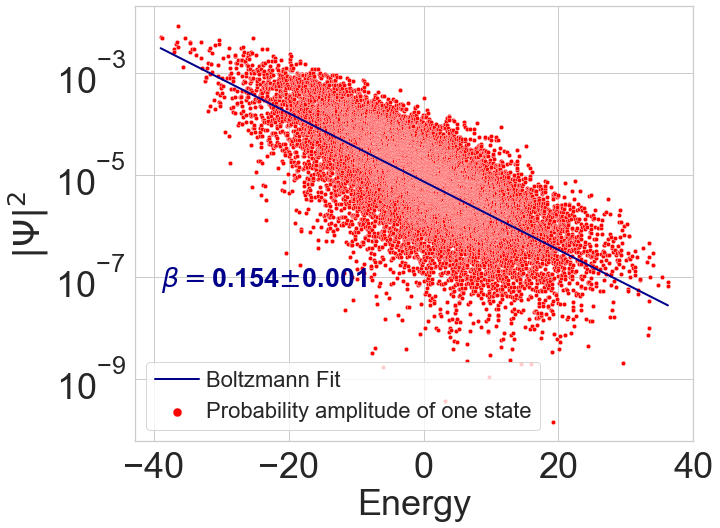

In [11]:
N = 14
fig, ax = plt.subplots()
circuit = experiment(ax,N,ptname='QUBO')
ax.legend(fontsize=22,handletextpad=0.3,markerscale=2)

Gamma = 0.2290129195015068 ; Theta = 0.7413550893991813


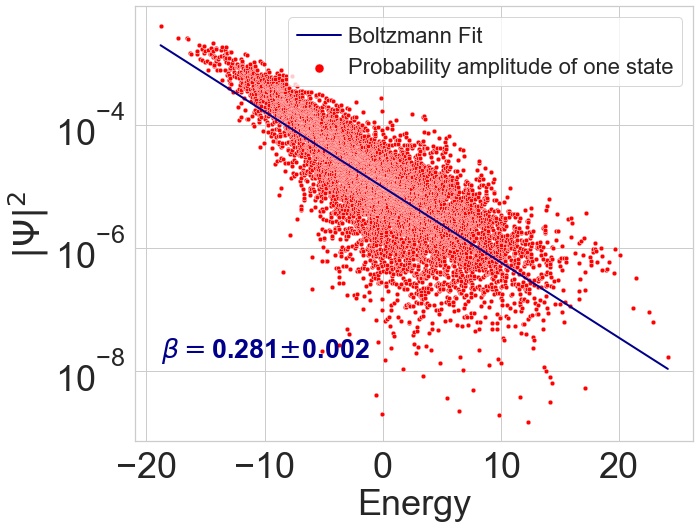

In [9]:
N = 14
fig, ax = plt.subplots()
circuit = experiment(ax,N,ptname='MAXCUT')
ax.legend(fontsize=22,handletextpad=0.3,markerscale=2)

Gamma = 0.1936578402090866 ; Theta = 0.7735440239364683


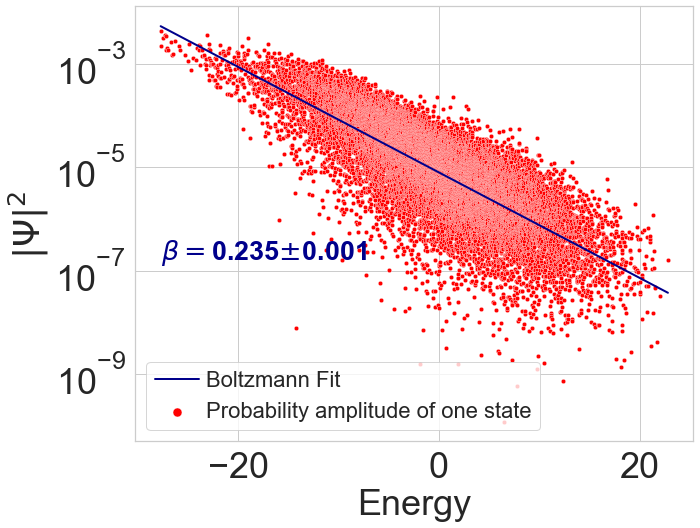

In [10]:
N = 14
fig, ax = plt.subplots()
circuit = experiment(ax,N,ptname='Random_Ising')
ax.legend(fontsize=22,handletextpad=0.3,markerscale=2)